* use with branch pv_fitting

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/mnt/scratch/xz498/needle_4/Auto4DSTEM/src')
sys.path.append('/mnt/scratch/xz498/needle_4/m3_learning/m3_learning/src')
import os

# from colorsys import hls_to_rgb
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import matplotlib.cm as cm
colors = plt.get_cmap('tab10')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from ipywidgets import interact

from scipy.ndimage import shift
# import math
import torch
# import torch.nn as nn
import torch.optim as optim

# from m3_learning.util.nn.Regularization.Regularizers import ContrastiveLoss, DivergenceLoss
from torch.nn import functional as F
# from torch.utils.data import DataLoader
from datetime import date
from tqdm import tqdm

import auto4dstem.nn.CC_ST_AE as CC_ST_AE
from m3_learning.nn.Fitter_AE.Fitter_AE import *
from m3_learning.nn.Fitter_AE.Fitter_functions import *
from m3_learning.nn.Fitter_AE import spot_fitting as spot
from m3_learning.viz.layout import imagemap, layout_fig
from m3_learning.util.file_IO import make_folder

import datetime
import csv
# import pandas as pd
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
# from pprint import pprint

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zhang-xinqiao. Use `wandb login --relogin` to force relogin
2024-09-27 20:17:14.696220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 20:17:14.718497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 20:17:14.731567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 20:17:14.757968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [2]:
import wandb
wandb.login()

True

In [3]:
def imshow_tensor(x):
    import matplotlib.pyplot as plt
    plt.imshow(x.detach().cpu().numpy());
    plt.colorbar()
    plt.show()
    
def make_colorbar(a):
    ax = a.axes
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(a, cax=cax)

In [4]:
import glob
file_names = ['20deg', '30deg', '50deg', '80deg', '100deg', '120deg', '130deg', '140deg', '150deg', 
                        'T_140Crampdown', 'T_120Crampdown', 'T_100Crampdown', 'T_80Crampdown', 'T_30C_rampdown', 'T_50Crampdown', 'T_20C_rampdown']
device = 'cuda:0'
def get_file_names(file_names):
    
    file_path_dict = {path.split('/')[-2]: path for path in glob.glob('/home/xz498/EMPAD/*/*.raw')}
    diff_list = [file_path_dict[name] for name in file_names]
    
    file_path_dict = {path.split('/')[-2]: path for path in glob.glob('/home/xz498/EMPAD/*/*.xml')}
    meta_list = [file_path_dict[name] for name in file_names]

    return diff_list, meta_list

diff_paths, meta_list = get_file_names(file_names)

### try Stacked_4DSTEM class

In [4]:
stacked_dset = Stacked_4DSTEM('./Needle4.h5',file_names, diff_paths, meta_list)

In [5]:
# stacked_dset.write_metadata(overwrite=True)
# TODO: fix

In [ ]:
stacked_dset.write_raw_data()

Raw data already written. Set overwrite=True


In [ ]:
test = stacked_dset.get_raw_data(0)

100%|██████████| 16/16 [01:19<00:00,  4.98s/it]


(array([  32.,  129., 1229., 5590., 6425., 2184.,  507.,  141.,   82.,
          65.]),
 array([ 4.67867231,  5.38912344,  6.09957409,  6.81002522,  7.52047634,
         8.23092747,  8.94137859,  9.65182877, 10.36227989, 11.07273102,
        11.78318214]),
 <BarContainer object of 10 artists>)

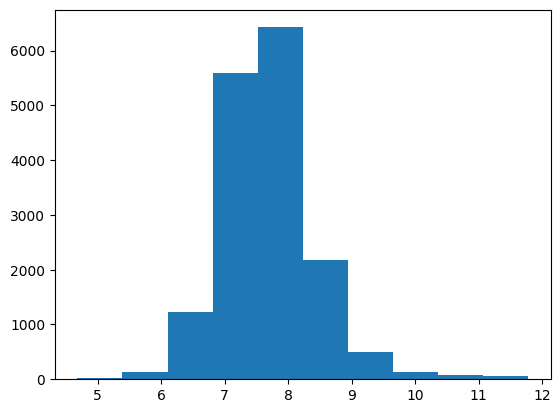

In [ ]:
# # scaling
# Stacked_4DSTEM.log(stacked_dset.h5_filepath, 'raw_data', 'processed_data')
# plt.hist(stacked_dset[0].flatten())

100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


(array([  32.,  129., 1229., 5590., 6425., 2184.,  507.,  141.,   82.,
          65.]),
 array([-4.09024906, -3.1337533 , -2.17725778, -1.22076201, -0.2642664 ,
         0.69222927,  1.64872491,  2.60522056,  3.56171632,  4.51821184,
         5.4747076 ]),
 <BarContainer object of 10 artists>)

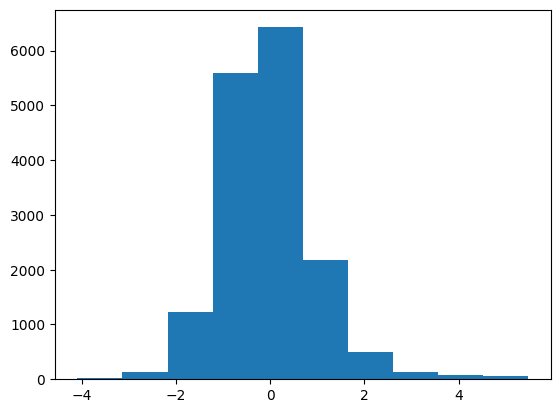

In [ ]:
# Stacked_4DSTEM.standard_scale(stacked_dset.h5_filepath, 'processed_data', 'processed_data')
# plt.hist(stacked_dset[0].flatten())

100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


(array([  32.,  129., 1229., 5590., 6425., 2184.,  507.,  141.,   82.,
          65.]),
 array([0.39098337, 0.45035374, 0.50972414, 0.56909448, 0.62846488,
        0.68783522, 0.74720562, 0.80657595, 0.86594635, 0.92531669,
        0.98468709]),
 <BarContainer object of 10 artists>)

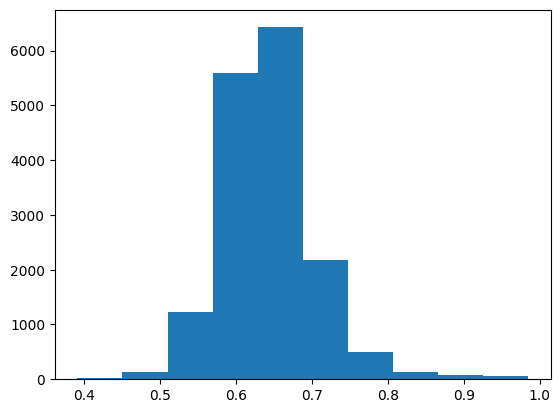

In [ ]:
# Stacked_4DSTEM.min_max_scale(stacked_dset.h5_filepath, 'processed_data', 'processed_data')
# plt.hist(stacked_dset[0].flatten())

### try Spot_Dataset

In [5]:
spot_dset = Spot_Dataset('/mnt/scratch/xz498/needle_4/Needle4.h5', 
                         diff_paths, meta_list, file_names=file_names,
                         device = device
)

In [6]:
diff,spots = spot_dset[0]

<Axes: >

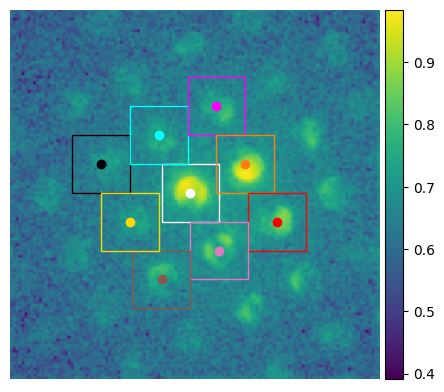

In [7]:
spot.draw_bounding_boxes(spot_dset,0,with_axis=0,with_colorbar=True)

<Axes: >

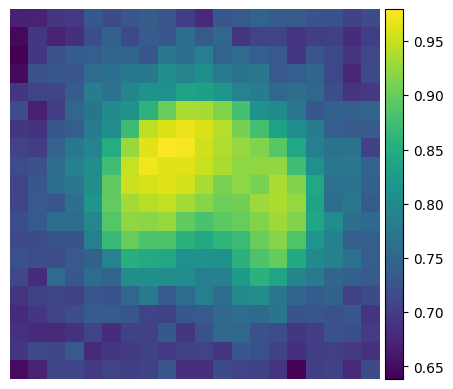

In [8]:
spot.show_tile(spot_dset,0,0,with_axis=0,with_colorbar=True)

### Test pv encoder/AE

In [9]:
from m3_learning.nn.Fitter_AE.Fitter_AE import *
from m3_learning.nn.Fitter_AE.Fitter_functions import generate_pseudovoigt_2D
from torch.utils.data import DataLoader

dataloader = DataLoader(spot_dset,shuffle=False,batch_size=16)
batch = next(iter(dataloader))
batch[0].shape,batch[1].shape

(torch.Size([16, 1, 128, 128]), torch.Size([16, 9, 1, 20, 20]))

In [10]:
pv_enc = PV_Encoder_2D(original_step_size=(spot_dset.r*2,spot_dset.r*2),
                        pooling_list=[2,2],
                        embedding_size=7,
                        conv_size=128,
                        num_fits=64)

In [11]:
pv_ae = PV_AE(encoder = PV_Encoder_2D, 
              encoder_init = {'original_step_size':(spot_dset.r*2,spot_dset.r*2),
                              'pooling_list':[2,2],
                              'embedding_size':7,
                              'conv_size':128,
                              'num_fits':64},
              fitter_function = generate_pseudovoigt_2D,
              limits = [1, 10, 10, 10, 10, 0.5],
              device = device).to(device)
emb,fits = pv_ae(batch[1].reshape(-1,1,20,20))
emb.shape,fits.shape

(torch.Size([144, 64, 7]), torch.Size([144, 20, 20]))

## Train pv-fitter to get optimal parameters 

In [ ]:
fitter = PV_Fitter_2D(fitter = generate_pseudovoigt_2D, spot_dset, 
                      encoder = PV_Encoder_2D, 
                      encoder_init = {'original_step_size':(spot_dset.r*2,spot_dset.r*2),
                                      'pooling_list':[2,2],
                                      'embedding_size':7,
                                      'conv_size':128},
                      autoencoder = PV_AE, 
                      autoencoder_init = {'fitter': generate_pseudovoigt_2D,
                                          'limits':[1, 10, 10, 10, 10, 0.5]},
                      device=device,folder=save_folder,
                      wandb_project = 'Needle4_PV_Fitter')

In [12]:
save_folder = make_folder('./../../../checkpoints/test_pv/')
fitter = PV_Fitter_2D(generate_pseudovoigt_2D, 
                      pv_enc,pv_ae,spot_dset,
                      device=device,folder=save_folder,
                      wandb_project = 'Needle4_PV_Fitter')

In [13]:
fitter.Train(spot_dset,epoch_=1,epochs=50,minibatch_logging_rate=1024,
             coef_1=lambda x: 2e-5*(x%10), ln_parm=lambda x:6/(x+3))

100%|██████████| 8192/8192 [16:52<00:00,  8.09it/s]


Epoch: 001/050 | Train Loss: 0.0107
.............................


100%|██████████| 8192/8192 [16:55<00:00,  8.07it/s]


Epoch: 002/050 | Train Loss: 0.0197
.............................


100%|██████████| 8192/8192 [16:38<00:00,  8.20it/s]


Epoch: 003/050 | Train Loss: 0.0281
.............................


100%|██████████| 8192/8192 [16:38<00:00,  8.21it/s]


Epoch: 004/050 | Train Loss: 0.0358
.............................


100%|██████████| 8192/8192 [16:36<00:00,  8.22it/s]


Epoch: 005/050 | Train Loss: 0.0428
.............................


100%|██████████| 8192/8192 [16:38<00:00,  8.20it/s]


Epoch: 006/050 | Train Loss: 0.0489
.............................


100%|██████████| 8192/8192 [16:31<00:00,  8.26it/s]


Epoch: 007/050 | Train Loss: 0.0543
.............................


100%|██████████| 8192/8192 [16:31<00:00,  8.27it/s]


Epoch: 008/050 | Train Loss: 0.0579
.............................


 29%|██▊       | 2346/8192 [04:53<12:11,  7.99it/s]


KeyboardInterrupt: 

In [14]:
fitter.pxs=225

In [15]:
# checkpoint = '/home/xz498/needle_4/m3_learning/checkpoints/test_pv/(2024-09-20)_epoch:0009_lr:0.00003_trainloss:0.0005.pkl'

checkpoint = '/home/xz498/needle_4/m3_learning/checkpoints/test_pv/(2024-09-24)_epoch:0000_lr:0.00003_trainloss:0.0001.pkl'

fitter.load_weights(checkpoint)
fitter.load_loss_data(checkpoint)

Generated available
Generated available


(0,
 {'ln_loss': 0.0,
  'masking_loss': 7.315448788958179e-05,
  'train_loss': 7.315448788958179e-05},
 {'pxs': 11.0,
  'coef_1': 0.0,
  'coef_2': 0,
  'coef_3': 0,
  'coef_4': 0,
  'coef_5': 0,
  'ln_parm': 2.0})

In [16]:
# fitter.Train(spot_dset,epochs=10)

In [17]:
fitter.train=False
fitter.get_embedding(spot_dset)

100%|██████████| 8192/8192 [13:39<00:00, 10.00it/s]


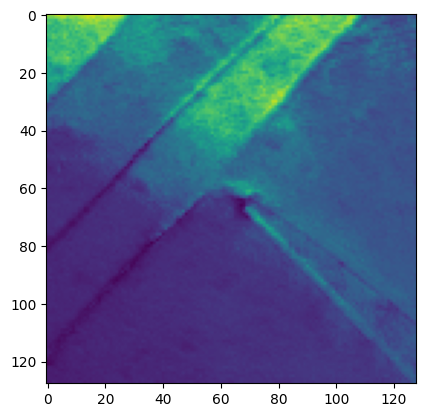

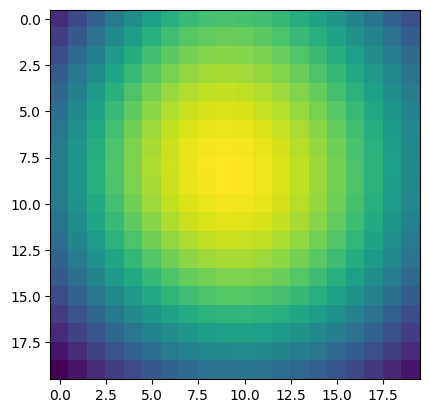

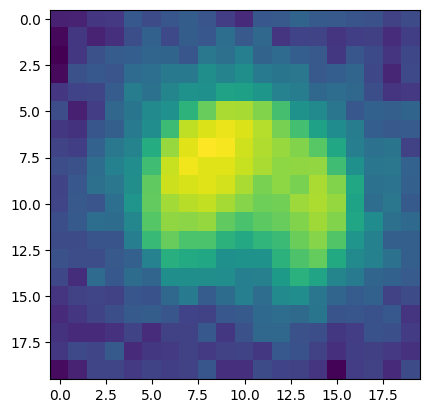

In [18]:
with fitter.open_embedding_h() as h:
    emb = h[f'embedding_{fitter.check}'][:128*128,0].mean(axis=1)
    fits = h[f'fits_{fitter.check}'][:128*128]
    input_ = spot_dset[:128*128][1].reshape(-1,1,20,20)
    plt.imshow(emb[:,0].reshape(128,128));plt.show()
    plt.imshow(fits[0,0]);plt.show()
    plt.imshow(input_[0,0].detach().cpu().numpy());plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
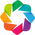

In [19]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')

with fitter.open_embedding_h() as h:
    emb = h[f'embedding_{fitter.check}'][:128*128] # (16384, 9, 64, 8)
    fits = h[f'fits_{fitter.check}'][:128*128] # (16384, 9, 20, 20)
    diff,spots = spot_dset[:128*128] # [16384, 1, 128, 128], [9, 16384, 1, 20, 20]
        

def view_spot(d,s):
    fitted = hv.Image(fits[d,s]).opts(axiswise=True,shared_axes=False,
                                      width=350,height=300,
                                      cmap='viridis',colorbar=True,
                                      title=f'fitted spot {s} diff {d}')
    raw = hv.Image(spots[s,d,0].detach().cpu().numpy()).opts(axiswise=True,shared_axes=False,
                                      width=350,height=300,
                                      cmap='viridis',colorbar=True,
                                      title=f'raw spot {s} diff {d}')
    return (fitted+raw).opts(axiswise=True,shared_axes=False)

def view_img(a,b):
    fitted_imgs = []
    raw_imgs = []
    for s in range(9):
        fitted_imgs.append( hv.Image(fits[:,s,a,b]).opts(axiswise=True,shared_axes=False,
                                        width=350,height=300,
                                        cmap='viridis',colorbar=True,
                                        title=f'fitted spot {s}') )
        raw_imgs.append( hv.Image(spots[s,:,0,a,b]).opts(axiswise=True,shared_axes=False,
                                        width=350,height=300,
                                        cmap='viridis',colorbar=True,
                                        title=f'fitted spot {s}') )
    return fitted_imgs,raw_imgs

def view_diff_params(s,c):
    par_names=['A','x0','y0','sigma_x','sigma_y','nu','theta']
    panels = []
    for i in range(7):
        panels.append(hv.Image(emb[:,s,c,i].reshape(128,128)).opts(axiswise=True,shared_axes=False,
                                      width=350,height=300,
                                      cmap='viridis',colorbar=True,
                                      title=f'{par_names[i]} spot {s} diff {c}'))
    return hv.Layout(panels).cols(3)

In [20]:
d_slider = pn.widgets.IntSlider(name='diffraction', start=0, end=128*128-1, value=0)
s_slider = pn.widgets.IntSlider(name='spot', start=0, end=8, value=0)
c_slider = pn.widgets.IntSlider(name='channel', start=0, end=63, value=0)

<Axes: >

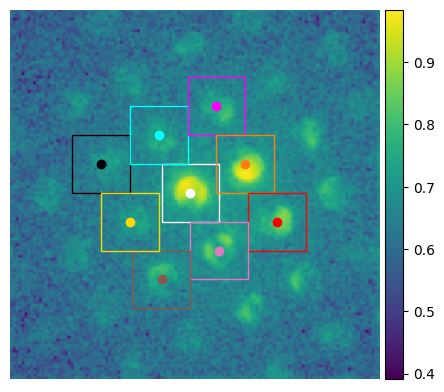

In [21]:
spot.draw_bounding_boxes(spot_dset,0,with_axis=0,with_colorbar=True)

In [22]:
# Create DynamicMap with the stream parameters
dmap = hv.DynamicMap(pn.bind(view_spot, d=d_slider, s=s_slider) ).opts(axiswise=True, shared_axes=False)
pn.Column(pn.Row(d_slider,s_slider),dmap)

BokehModel(combine_events=True, render_bundle={'docs_json': {'95d18b88-611f-40d9-9e18-6e91376d22a4': {'version…

In [ ]:
dmap.clear()

In [23]:
dmap_parms = hv.DynamicMap(pn.bind(view_diff_params, s=s_slider, c=c_slider) ).opts(axiswise=True, shared_axes=False)
pn.Column(pn.Row(s_slider,c_slider),dmap_parms)

BokehModel(combine_events=True, render_bundle={'docs_json': {'58255bd8-44bc-4258-b205-029ce168824a': {'version…

In [47]:
emb.shape,fits.shape,diff.shape,spots.shape

((16384, 9, 64, 8),
 (16384, 9, 20, 20),
 torch.Size([16384, 1, 128, 128]),
 torch.Size([9, 16384, 1, 20, 20]))

## test joint utils

In [ ]:
from Auto4DSTEM.nn.CC_ST_AE import PV_CC_ST_AE_utils

ModuleNotFoundError: No module named 'Auto4DSTEM.nn'